In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt
# Creating custom legend handles
import matplotlib.lines as mlines
import sys
import os
import re
from tqdm import tqdm

def path_link(path:str):
    sys.path.append(path)

path_link('/home/jpierre/v2/lib')

import utils2.testing_gen as gen
import utils2.loading as load
import utils2.nn_gen as nn_gen
from utils2.tools import array2List

from NNSimulator import genSim, getSimulationData


from norm import normalizeGraph

from measure import Param_eval, EvaluationCfg, evaluateLoad, saveLoader


yessss sir
>>>>>>>>>>>> LOADOING THE V2 OF FEATURES
fndjngkjdfs --NN-sim
update


In [2]:
def errorsDiv(pred, gt):
    
    v = np.pi * 2
    anglePred = np.arctan2(pred[:, 1], pred[:, 0])
    angleGT = np.arctan2(gt[:, 1], gt[:, 0])

    normPred = np.linalg.norm(pred, axis=-1)
    normGT = np.linalg.norm(gt, axis=-1)

    errorNorm = np.abs(normPred - normGT)
    errorAngle = errorAngle = np.abs((anglePred - angleGT + np.pi) % (2 * np.pi) - np.pi)

    return errorAngle, errorNorm

In [3]:
import stats.stats_re as stats
import yaml

In [4]:
DEVICE = torch.device("cuda" if torch.cuda.is_available() else 'cpu')

PATH = ['/home/jpierre/v2/results_end/files/roll/simplest']
MODEL_PATH = '/home/jpierre/v2/results_end/models'
MODEL = 'simplest'

In [5]:
def loadModel(modelName:str, d, path = MODEL_PATH):
    """ 
    Function to import the model

    Args:
    -----
        - `modelName`: name of the model
        - `inputShape`: inout shape of the NN
        - `edges_shape`: edge shape of the NN
        - `path`: path where the models are
    """

    sys.path.append(path)

    loadFun = __import__(f'{modelName}', fromlist = ('loadNetwork'))

    #model = loadFun.loadNetwork(inputShape, edges_shape)
    model = loadFun.loadNetwork(d)

    return model


In [6]:
def getModel(cfg, std_path, device = DEVICE, model_path = MODEL_PATH):

    with open(cfg, 'r') as file:
        cfg = yaml.safe_load(file) 

    trainingInfos = cfg['training']

    d_model = trainingInfos['cfg_mod'][f'{trainingInfos["cfg_mod"]["model_name"]}']


    model = loadModel(MODEL, d_model, model_path)



    state_dict = torch.load(std_path, map_location = 'cpu')

    model.load_state_dict(state_dict)

    model.eval()

    model = model.to(device)

    return model

    

In [7]:
class id():
    def __init__(self):
        self.dropout = None
        self.l1 = None
        self.path = None
        self.loss = None
        self.eval_loss = None
        self.eval_sim_loss = None
        self.data_type = None
        self.action_r = None
        self.cfg = None


    def load_id(self, path:str):
        try:
            if 'scaleL1' in path:
                nb_layer_match = re.search(r'scaleL1-(\d+\.\d+|\d+)', path)
                self.l1 = float(nb_layer_match.group(1))
            dropout_match = re.search(r'dropout-(\d+)', path)


            if 'action' in path:
                self.action_r = 1
            else:
                0



            self.dropout = int(dropout_match.group(1))

            if 'noisy' in path:
                self.data_type = 'noisy'

            elif 'normal' in path:
                self.data_type = 'normal'
            
            
            self.path = path

            self.loss = os.path.join(os.path.dirname(path), 'loss_list.npy')
            self.eval_loss = os.path.join(os.path.dirname(path), 'eval_list.npy')
            self.eval_sim_loss = os.path.join(os.path.dirname(path), 'eval_sim_list.npy')
            self.cfg = os.path.join(os.path.dirname(os.path.dirname(path)), 'cfg.yml')
        except:
            print(path)

    def label(self):
        return f'{self.data_type}_action-{self.action_r}_dropout{self.dropout}_l1-{self.l1}'
    

def get_path_models(path):

    res = []

    for root, dirs, files in os.walk(path):
        for file in files:
            if file.endswith('best.pt'):
                id_model = id()
                id_model.load_id(os.path.join(root, file))

                res.append(id_model)


    return res




res = []

for path in PATH:
    res.extend(get_path_models(path))

In [8]:
for r in res:
    print(f'{r.path} >>> {r.__dict__}')

/home/jpierre/v2/results_end/files/roll/simplest/mt-simplest_noisy_scaleL1-0.0001_dropout-0/model_trained/simplest_best.pt >>> {'dropout': 0, 'l1': 0.0001, 'path': '/home/jpierre/v2/results_end/files/roll/simplest/mt-simplest_noisy_scaleL1-0.0001_dropout-0/model_trained/simplest_best.pt', 'loss': '/home/jpierre/v2/results_end/files/roll/simplest/mt-simplest_noisy_scaleL1-0.0001_dropout-0/model_trained/loss_list.npy', 'eval_loss': '/home/jpierre/v2/results_end/files/roll/simplest/mt-simplest_noisy_scaleL1-0.0001_dropout-0/model_trained/eval_list.npy', 'eval_sim_loss': '/home/jpierre/v2/results_end/files/roll/simplest/mt-simplest_noisy_scaleL1-0.0001_dropout-0/model_trained/eval_sim_list.npy', 'data_type': 'noisy', 'action_r': None, 'cfg': '/home/jpierre/v2/results_end/files/roll/simplest/mt-simplest_noisy_scaleL1-0.0001_dropout-0/cfg.yml'}
/home/jpierre/v2/results_end/files/roll/simplest/mt-simplest_normal_scaleL1-0.0001_dropout-0/model_trained/simplest_best.pt >>> {'dropout': 0, 'l1': 

# =====================

In [9]:
normal_runs = []
noisy_runs = []


for r in res:
    if r.data_type == 'normal':
        normal_runs.append(r)
    elif r.data_type == 'noisy':
        noisy_runs.append(r)
        
        
        
normal_models_l1 = []
normal_l1_val = []

noisy_models_l1 = []
noisy_l1_val = []


for r in normal_runs:
    if r.data_type == 'normal':
        if r.dropout == 0:
            l1_val = r.l1
            normal_l1_val.append(l1_val)


            normal_models_l1.append(r)



for r in noisy_runs:
    if r.data_type == 'noisy':
        if r.dropout == 0:
            l1_val = r.l1
            noisy_l1_val.append(l1_val)


            noisy_models_l1.append(r)


# ===================

In [10]:
NB_SIM = 5


def getParams():
    params = gen.Parameters_Simulation()  


    params.dt = 0.001
    params.v0 = 60
    params.k = 70
    params.epsilon = 0.5
    params.tau = 3.5
    params.R = 1
    params.N = 200
    params.boundary = 100
    params.nbStep = 1000


    params.noisy = 0        # function dans utils
    params.features_x = 'delta'
    params.features_edge = 'first'


    return params


params1 = getParams()

params2 = getParams()
params2.noisy = 1


data_gt_1  = gen.get_mult_data(params1, NB_SIM)
graphs_gt_1  = gen.sims2Graphs(data_gt_1, params1.features_x)
data_gt_list_1 = array2List(data_gt_1)


#data_gt_2 = gen.get_mult_data(params2, NB_SIM)
#graphs_gt_2 = gen.sims2Graphs(data_gt_2, params2.features_x)
#data_gt_list_2 = array2List(data_gt_2)

0
v0:60, tau:3.5, k:70, epsilon:0.5


100%|██████████| 999/999 [00:36<00:00, 27.66it/s]


0
v0:60, tau:3.5, k:70, epsilon:0.5


100%|██████████| 999/999 [00:29<00:00, 33.40it/s]


0
v0:60, tau:3.5, k:70, epsilon:0.5


100%|██████████| 999/999 [00:25<00:00, 39.78it/s]


0
v0:60, tau:3.5, k:70, epsilon:0.5


100%|██████████| 999/999 [00:22<00:00, 43.57it/s]


0
v0:60, tau:3.5, k:70, epsilon:0.5


100%|██████████| 999/999 [00:21<00:00, 46.25it/s]


In [11]:
start = 250
length = 100

stop = start+length

In [12]:

a = np.linspace(0, 5, 100)
b= np.linspace(-5, 5, 100)



MSD_base_normal = stats.MSD_stat(data_gt_1[:, start:stop])
RDF_base_normal  = stats.apply_rdf(data_gt_1[:, start:stop])
SCAT_base_normal = stats.applySelfScattering(data_gt_1[:, start:stop])
DISTR_base_normal = stats.apply_hist(data_gt_1, a, b)
SUM_base_normal = stats.sumSpeeds(data_gt_1[:, start:stop])        # issue wiht libtrayr

100%|██████████| 100/100 [00:01<00:00, 73.62it/s]


In [13]:
# laoders
import dataLoading as dl
from torch_geometric.loader import DataLoader
from torch.utils.data import DataLoader as DataLoaderPy




PATH_BASE = '/home/jpierre/v2/path_datasets'

def getLoader(path, batch_size = 32, shuffleBool = True, root = None, jsonFile = None, mode = 'training'):
    datasetTraining = dl.DataLoader2(root, path = path, jsonFile = jsonFile, mode = mode)
    loader = DataLoader(datasetTraining, batch_size=batch_size, shuffle = shuffleBool)
    
    return loader

# 1s-tep loader
p_data = '/scratch/users/jpierre/mew_0.001_normal_v2'
#p_data = '/scratch/users/jpierre/mew_0.001_noisy_v2'

batchSizeEval = 128
p_json = os.path.join(PATH_BASE, f'{p_data.split("/")[-1]}.json')

loaderEval = getLoader(p_data, batch_size = batchSizeEval, jsonFile = p_json, mode = 'validation')


# rollout laoder

p_sim = os.path.join(p_data, 'validation/np_file')

loaderSim = dl.simLoader2(p_sim)
loaderSim = DataLoaderPy(loaderSim, batch_size=1, shuffle=False)

1it [00:00,  4.76it/s]


In [14]:
MSD_list_normal = []
RDF_list_normal = []
SCAT_list_normal = []
DISTR_list_normal = []
SUM_list_normal = []
MSE_rollout = []

a = np.linspace(0, 5, 100)
b= np.linspace(-5, 5, 100)



device = DEVICE


errors_list = []
std_errors_list = []
angles_error_list = []
norm_errors_list = []
angle_errors_std_list = []
norm_errors_std_list = []



sim_error_list = []
sim_error_std_list = []




for i in tqdm(range(len(normal_models_l1))):

    ## load model
    cfg = normal_models_l1[i].cfg
    std_path = normal_models_l1[i].path
    model = getModel(cfg, std_path)


    ## compute the trajectory

    data_pred = nn_gen.generate_sim_batch(model = model,
                                        gt = data_gt_1, 
                                        initId = start,
                                        nbStep = length,
                                        dt_scale = 1,
                                        device = DEVICE
                                        )

    # compute the stats

    msd = stats.MSD_stat(data_pred.copy())
    rdf = stats.apply_rdf(data_pred.copy())
    scat = stats.applySelfScattering(data_pred.copy())
    speed_distr = stats.apply_hist(data_pred.copy(), a, b)
    sum_speed = stats.sumSpeeds(data_pred.copy())
    mse_roll = stats.apply_mse_roll(data_pred.copy()[:, :length],data_gt_1.copy()[:, start:stop])



    MSD_list_normal.append(msd)
    RDF_list_normal.append(rdf)
    SCAT_list_normal.append(scat)
    DISTR_list_normal.append(speed_distr)
    SUM_list_normal.append(sum_speed)
    
    
    
    errors = []
    normError = []
    angleError = []
    
    for d, _ in tqdm(loaderEval, leave = False):
        d = d.to(device)
        d.x = d.x[:, 2:]
        d = normalizeGraph(d)
        pred = model(d)  
        
        d.y = torch.swapaxes(d.y, 0, 1)
        

        #evalLoss += torch.nn.functional.l1_loss(pred.reshape(-1), d.y[0, :, :].reshape(-1))
        
        
        errors.extend(torch.abs(pred - d.y[0, :, :]).cpu().detach().numpy().tolist())
        
        
        errorAngle, errorNorm = errorsDiv(pred.cpu().detach().numpy(), d.y[0, :, :].cpu().detach().numpy())
        
        normError.extend(errorNorm.tolist())
        angleError.extend(errorAngle.tolist())


    erros1 = np.mean(errors)
    errors_std = np.std(errors)

    angle_error = np.median(errorAngle)
    norm_error = np.median(normError)

    angle_std = np.std(errorAngle)
    norm_std  = np.std(normError)


    # add to the other lists
    errors_list.append(erros1)
    std_errors_list.append(errors_std)
    angles_error_list.append(angle_std)
    norm_errors_list.append(norm_error)
    angle_errors_std_list.append(angle_std)
    norm_errors_std_list.append(norm_std)
    
    
    
    
    ################
    
    
    eval_loss_list = []

    for d, _ in loaderSim:

        d = torch.squeeze(d, dim = 0).numpy()
        start_id = 8       # not 0
        res = getSimulationData(model, 15, d, i = start_id, device = DEVICE)
        L = res.shape[0]

        eval_loss_list.append(torch.nn.functional.l1_loss(res.reshape(-1), torch.from_numpy(d[start_id:(start_id + L), :, :].copy()).reshape(-1).to(device)).cpu().detach().numpy())

    
    
    sim_error_list.append(np.mean(eval_loss_list))
    sim_error_std_list.append(np.std(eval_loss_list))


  0%|          | 0/1 [00:00<?, ?it/s]

>>>> loading simplest
INFO >>> with NO encoder
INFO >>> with NO dropout



100%|██████████| 99/99 [00:00<00:00, 174.57it/s]

100%|██████████| 99/99 [00:00<00:00, 280.55it/s]

100%|██████████| 99/99 [00:00<00:00, 279.55it/s]

100%|██████████| 99/99 [00:00<00:00, 272.80it/s]

100%|██████████| 99/99 [00:00<00:00, 276.07it/s]

100%|██████████| 100/100 [00:01<00:00, 78.33it/s][A

100%|██████████| 100/100 [00:01<00:00, 78.26it/s][A

100%|██████████| 100/100 [00:01<00:00, 78.90it/s][A

100%|██████████| 100/100 [00:01<00:00, 77.61it/s]

100%|██████████| 100/100 [00:01<00:00, 78.73it/s][A

 49%|████▉     | 76/155 [01:23<00:50,  1.57it/s]


100%|██████████| 155/155 [02:12<00:00,  1.85it/s]
                                                 
100%|██████████| 15/15 [00:00<00:00, 272.58it/s]

100%|██████████| 15/15 [00:00<00:00, 284.31it/s]

100%|██████████| 15/15 [00:00<00:00, 284.84it/s]

100%|██████████| 15/15 [00:00<00:00, 275.20it/s]

100%|██████████| 15/15 [00:00<00:00, 280.22it/s]

100%|██████████| 15/15 [00:00<00:00, 283.95it/s]

100%|██████████| 15/15 [00:00<00:00, 285.93it/s]

100%|██████████| 15/15 [00:00<00:00, 296.20it/s]

100%|██████████| 15/15 [00:00<00:00, 295.11it/s]

100%|██████████| 15/15 [00:00<00:00, 281.22it/s]

100%|██████████| 15/15 [00:00<00:00, 298.11it/s]

100%|██████████| 15/15 [00:00<00:00, 302.25it/s]

100%|██████████| 15/15 [00:00<00:00, 297.30it/s]

100%|██████████| 15/15 [00:00<00:00, 299.14it/s]

100%|██████████| 15/15 [00:00<00:00, 305.62it/s]

100%|██████████| 15/15 [00:00<00:00, 292.80it/s]

100%|██████████| 15/15 [00:00<00:00, 287.26it/s]

100%|██████████| 15/15 [00:00<00:00, 290.09it/s]



In [15]:
print(f'errors ==>  {errors_list}')
print(f'errors std ==> {std_errors_list}')
print(f'angle_error ==>  {angles_error_list}')
print(f'angle_std std ==> {angle_errors_std_list}')
print(f'norm_errors_list ==>  {norm_errors_list}')
print(f'norm_errors_std_list std ==> {norm_errors_std_list}')

print(f'sim_error_list ==>  {sim_error_list}')
print(f'sim_error_std_list std ==> {sim_error_std_list}')

errors ==>  [0.004682939634801477]
errors std ==> [0.004592077687187032]
angle_error ==>  [0.075393796]
angle_std std ==> [0.075393796]
norm_errors_list ==>  [0.0073654018342494965]
norm_errors_std_list std ==> [0.005119779649561054]
sim_error_list ==>  [0.0710268761311378]
sim_error_std_list std ==> [0.0015295603087666378]


# ======================

In [16]:
l1 = [normal_models_l1[i].l1 for i in range(len(normal_models_l1))]

print(l1)

[0.0001]


In [17]:
l1[-1] = '0.0001 - action-reaction'

In [18]:
colors = ['blue', 'green', 'orange', 'red', 'purple']


In [19]:
limit_msd = 99
limit_scat = 99


In [20]:
print(l1)

['0.0001 - action-reaction']


In [21]:
res_msd = []

(5, 99)


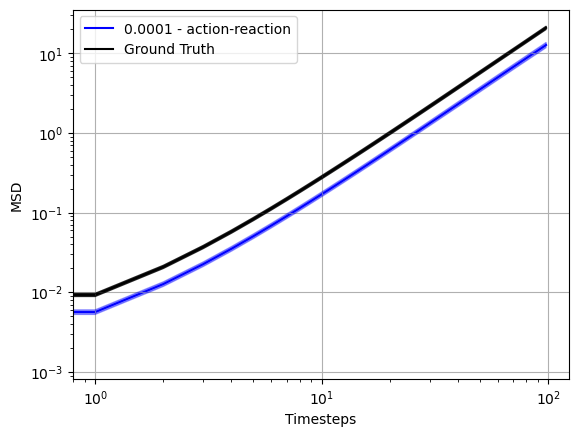

In [22]:
# plot of MSD


for i in range(len(l1)):
    print(MSD_list_normal[i][:limit_msd].shape)
    msd_mean = np.mean(MSD_list_normal[i][:, :limit_msd], axis = 0)
    msd_std = np.std(MSD_list_normal[i][:, :limit_msd], axis = 0)
    x = np.arange(limit_msd)
    plt.loglog(x, msd_mean, color = colors[i], zorder = 1, label = str(l1[i]))
    plt.fill_between((x), (msd_mean - msd_std), (msd_mean+msd_std), color = colors[i], alpha = 0.4, zorder = 2)
    
    res_msd.append(msd_mean)
    
msd_mean = np.mean(MSD_base_normal[:, :limit_msd], axis = 0)
msd_std = np.std(MSD_base_normal[:, :limit_msd], axis = 0)
x = np.arange(limit_msd)
plt.loglog(x, msd_mean, color = 'k', zorder = 1, label = 'Ground Truth')
plt.fill_between((x), (msd_mean - msd_std), (msd_mean+msd_std), color = 'k', alpha = 0.8, zorder = 2)
    
plt.xlabel('Timesteps')
plt.ylabel('MSD')
plt.grid()
plt.legend()
plt.savefig('MSD-simplest-normal.png')



In [23]:
msd_gt = np.mean(MSD_base_normal[:, :limit_msd], axis = 0)

In [24]:
for i in range(len(res_msd)):
    delta = (msd_gt - res_msd[i]) ** 2
    print(f'l1: {l1[i]} >>>> {np.mean(delta)} +- {np.std(delta)}')

l1: 0.0001 - action-reaction >>>> 13.728236969376724 +- 18.0840147218255


### 

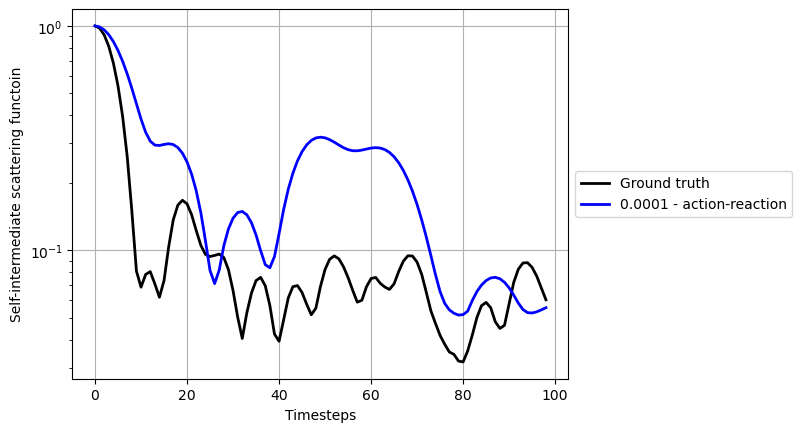

In [25]:
# plot of SSF

res_scat = []


ssf_mean = np.mean(SCAT_base_normal[:, :limit_scat], axis = 0)
ssf_std = np.std(SCAT_base_normal[:, :limit_scat], axis = 0)
t = np.arange(limit_scat)
plt.semilogy(t, ssf_mean, color = 'k', lw=2, label = 'Ground truth')
#plt.fill_between(t, ssf_mean -ssf_std,  ssf_mean + ssf_std, color = 'k', alpha = 0.2, zorder = 3)


for i in range(len(l1)):
    #print(MSD_list_normal[i][:limit_scat].shape)
    ssf_mean = np.mean(SCAT_list_normal[i][:, :limit_scat], axis = 0)
    ssf_std = np.std(SCAT_list_normal[i][:, :limit_scat], axis = 0)
    t = np.arange(limit_scat)
    res_scat.append(ssf_mean)
    plt.semilogy(t, ssf_mean, color = colors[i], lw=2, label = str(l1[i]))
    #plt.fill_between(t, ssf_mean -ssf_std,  ssf_mean + ssf_std, color = colors[i], alpha = 0.4, zorder = 2)
    
plt.xlabel('Timesteps')
plt.ylabel('Self-intermediate scattering functoin')
plt.grid()
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

plt.savefig('scat-simplest.png', bbox_inches='tight')
plt.show()

In [26]:
scat_gt = np.mean(SCAT_base_normal[:, :limit_scat], axis = 0)

for i in range(len(res_scat)):
    delta = (scat_gt - res_scat[i]) ** 2
    print(f'l1: {l1[i]} >>>> {np.mean(delta)} +- {np.std(delta)}')

l1: 0.0001 - action-reaction >>>> 0.023364067029565252 +- 0.03075818351450411


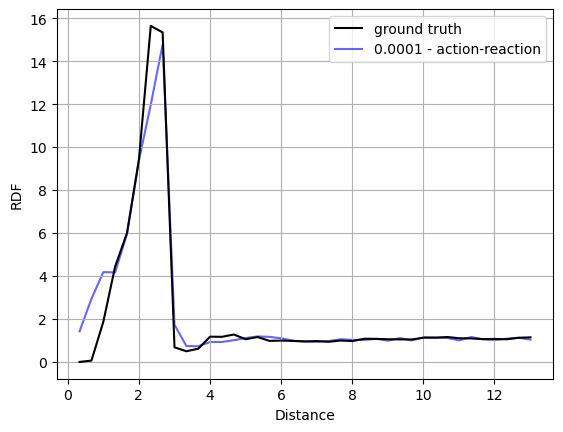

In [27]:
mean_res, std_res, r = RDF_base_normal
lim_rdf = 40

res_rdf = []


mean_res, std_res, r = mean_res[1:lim_rdf], std_res[1: lim_rdf], r[1: lim_rdf]

plt.plot(r, mean_res, color = 'k', label = 'ground truth', zorder = 2)
#plt.fill_between(r, mean_res - std_res, mean_res+ std_res, color = 'k', alpha = 0.4)

for i in range(len(l1)):
    #print(MSD_list_normal[i][:limit_scat].shape)
    mean_res, std_res, r = RDF_list_normal[i]
    mean_res, std_res, r = mean_res[1:lim_rdf], std_res[1: lim_rdf], r[1: lim_rdf]
    
    plt.plot(r, mean_res, color = colors[i], label = str(l1[i]), alpha = 0.6, zorder = 1)
    #plt.fill_between(r, mean_res -std_res,  mean_res + std_res, color = colors[i], alpha = 0.4, zorder = 2)
    
    res_rdf.append(mean_res)

plt.xlabel('Distance')
plt.ylabel('RDF')
plt.grid()
plt.legend()


plt.savefig('rdf-simplest.png')
plt.show()

In [28]:
mean_res, std_res, r = RDF_base_normal
mean_res, std_res, r = mean_res[1:lim_rdf], std_res[1: lim_rdf], r[1: lim_rdf]
rdf_gt = np.mean(mean_res, axis = 0)

for i in range(len(res_rdf)):
    delta = (rdf_gt - res_rdf[i]) ** 2
    print(f'l1: {l1[i]} >>>> {np.mean(delta)} +- {np.std(delta)}')

l1: 0.0001 - action-reaction >>>> 9.486270808054085 +- 29.52473353851523


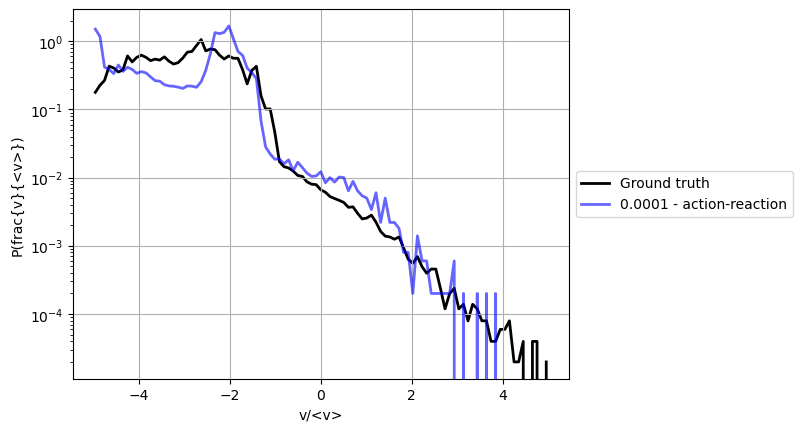

In [29]:
magn_base, x_speed, y_speed = DISTR_base_normal

magn_base_mean = np.mean(magn_base, axis = 0)
magn_base_std = np.std(magn_base, axis = 0)

res_magn_distr = []


fig=plt.figure()
db=b[1]-b[0]
plt.grid()
plt.semilogy(b[1:]-db/2,magn_base_mean,'k',lw=2, zorder = 1, label = 'Ground truth')
#plt.fill_between(b[1:]-db/2, magn_base_mean - magn_base_std, magn_base_mean + magn_base_std, color = 'r', alpha = 0.4)


for i in range(len(l1)):
    magn, x, y = DISTR_list_normal[i]
    magn_base_mean = np.mean(magn, axis = 0)
    magn_base_std = np.std(magn, axis = 0)
    plt.semilogy(b[1:]-db/2,magn_base_mean, color = colors[i],lw=2, label = str(l1[i]), zorder = 2, alpha = 0.6)
    
    res_magn_distr.append(magn_base_mean)



plt.xlabel('v/<v>')
plt.ylabel('P(frac{v}{<v>})')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

plt.savefig('speed-magn-simplest.png', bbox_inches='tight')
plt.show()

In [30]:
magn_base, x_speed, y_speed = DISTR_base_normal

magn_base_mean = np.mean(magn_base, axis = 0)

magn_gt = magn_base_mean

for i in range(len(res_magn_distr)):
    delta = (magn_gt - res_magn_distr[i]) ** 2
    print(f'l1: {l1[i]} >>>> {np.mean(delta)} +- {np.std(delta)}')

l1: 0.0001 - action-reaction >>>> 0.08360551553458231 +- 0.24868776527095618


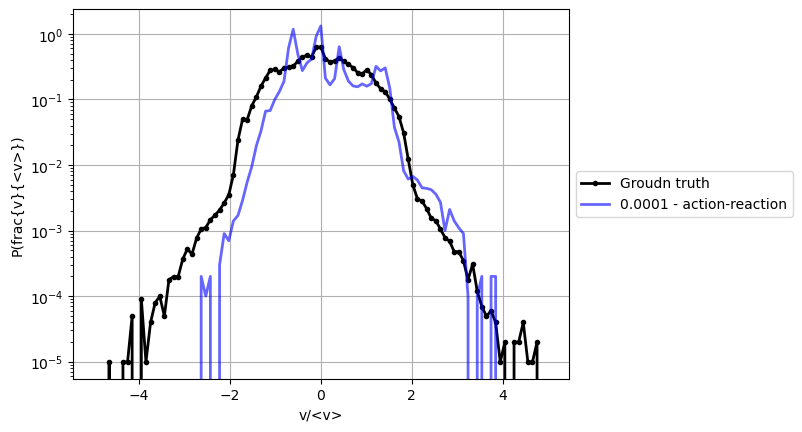

In [31]:
magn_base_mean = np.mean(x_speed, axis = 0)
magn_base_std = np.std(x_speed, axis = 0)

res_magn_x = []


fig=plt.figure()
db=b[1]-b[0]
plt.grid()
plt.semilogy(b[1:]-db/2,magn_base_mean,'k.-',lw=2, label = 'Groudn truth')
#plt.fill_between(b[1:]-db/2, magn_base_mean - magn_base_std, magn_base_mean + magn_base_std, color = 'r', alpha = 0.4)


for i in range(len(l1)):
    magn, x, y = DISTR_list_normal[i]
    x_base_mean = np.mean(x, axis = 0)
    x_base_std = np.std(x, axis = 0)
    plt.semilogy(b[1:]-db/2,x_base_mean, color = colors[i],lw=2, label = str(l1[i]), zorder = 2, alpha = 0.6)
    
    res_magn_x.append(x_base_mean)

    
plt.xlabel('v/<v>')
plt.ylabel('P(frac{v}{<v>})')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

plt.savefig('speed-x-simplest.png', bbox_inches='tight')
plt.show()

In [32]:
magn_base, x_speed, y_speed = DISTR_base_normal

magn_base_mean = np.mean(x_speed, axis = 0)

magn_gt = magn_base_mean

for i in range(len(res_magn_x)):
    delta = (magn_gt - res_magn_x[i]) ** 2
    print(f'l1: {l1[i]} >>>> {np.mean(delta)} +- {np.std(delta)}')

l1: 0.0001 - action-reaction >>>> 0.019497525409707672 +- 0.08775390038911254


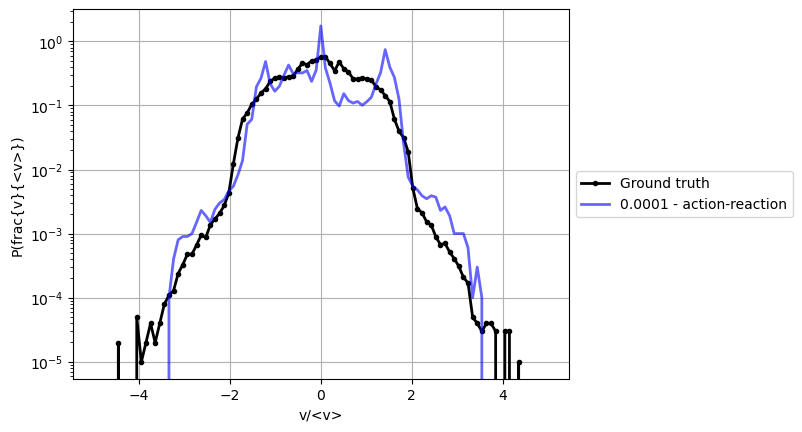

In [33]:
magn_base_mean = np.mean(y_speed, axis = 0)
magn_base_std = np.std(y_speed, axis = 0)

res_magn_y = []


fig=plt.figure()
db=b[1]-b[0]
plt.grid()
plt.semilogy(b[1:]-db/2,magn_base_mean,'k.-',lw=2, label = 'Ground truth')
#plt.fill_between(b[1:]-db/2, magn_base_mean - magn_base_std, magn_base_mean + magn_base_std, color = 'r', alpha = 0.4)


for i in range(len(l1)):
    magn, x, y = DISTR_list_normal[i]
    y_base_mean = np.mean(y, axis = 0)
    y_base_std = np.std(y, axis = 0)
    plt.semilogy(b[1:]-db/2,y_base_mean, color = colors[i],lw=2, label = str(l1[i]), zorder = 2, alpha = 0.6)
    
    res_magn_y.append(y_base_mean)

plt.xlabel('v/<v>')
plt.ylabel('P(frac{v}{<v>})')




plt.xlabel('v/<v>')
plt.ylabel('P(frac{v}{<v>})')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

plt.savefig('speed-y-simplest.png', bbox_inches='tight')
plt.show()

In [34]:
magn_base, x_speed, y_speed = DISTR_base_normal

magn_base_mean = np.mean(y_speed, axis = 0)

magn_gt = magn_base_mean

for i in range(len(res_magn_y)):
    delta = (magn_gt - res_magn_y[i]) ** 2
    print(f'l1: {l1[i]} >>>> {np.mean(delta)} +- {np.std(delta)}')

l1: 0.0001 - action-reaction >>>> 0.026950711208325602 +- 0.14345973255312086


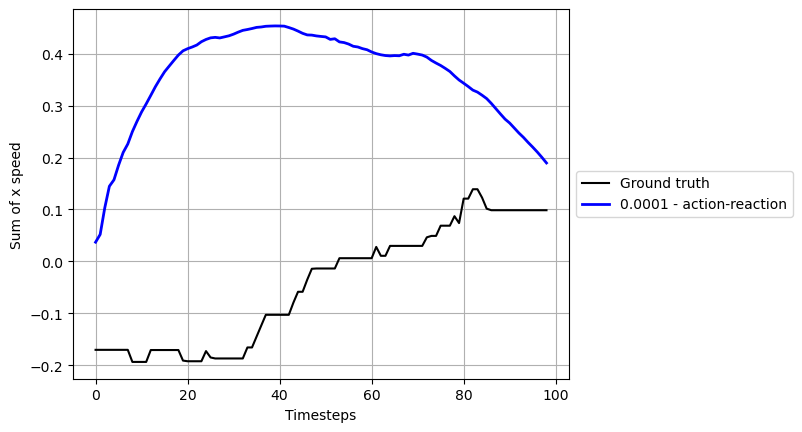

In [35]:
mean_sum = np.mean(SUM_base_normal, axis = 0)
std_sum = np.std(SUM_base_normal, axis = 0)

liit_sum = 300

plt.plot(mean_sum[:liit_sum, 0], color = 'k', label = 'Ground truth')


for i in range(len(l1)):
    sum_mean = np.mean(SUM_list_normal[i], axis = 0)
    sum_std = np.std(SUM_list_normal[i], axis = 0)
    
    plt.plot(sum_mean[:liit_sum, 0], color = colors[i], lw=2, label = str(l1[i]))

    
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.grid()
plt.xlabel('Timesteps')
plt.ylabel('Sum of x speed')

plt.savefig('speed-sum-x-simplest.png', bbox_inches='tight')
plt.show()

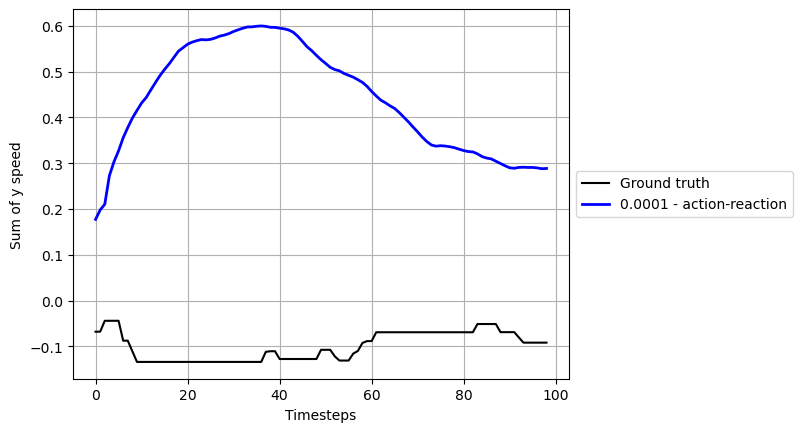

In [36]:
mean_sum = np.mean(SUM_base_normal, axis = 0)
std_sum = np.std(SUM_base_normal, axis = 0)

liit_sum = 300

plt.plot(mean_sum[:liit_sum, 1], color = 'k', label = 'Ground truth')


for i in range(len(l1)):
    sum_mean = np.mean(SUM_list_normal[i], axis = 0)
    sum_std = np.std(SUM_list_normal[i], axis = 0)
    
    plt.plot(sum_mean[:liit_sum, 1], color = colors[i], lw=2, label = str(l1[i]))

    
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.grid()
plt.xlabel('Timesteps')
plt.ylabel('Sum of y speed')


#plt.ylim([np.min(mean_sum[:liit_sum, 1])- 0.5, np.max(mean_sum[:liit_sum, 1])+ 0.5])

plt.savefig('speed-sum-y-simplest.png', bbox_inches='tight')
plt.show()

# =======================
# =======================

In [37]:
NB_SIM = 5


def getParams():
    params = gen.Parameters_Simulation()  


    params.dt = 0.001
    params.v0 = 60
    params.k = 70
    params.epsilon = 0.5
    params.tau = 3.5
    params.R = 1
    params.N = 200
    params.boundary = 100
    params.nbStep = 1000


    params.noisy = 0        # function dans utils
    params.features_x = 'delta'
    params.features_edge = 'first'


    return params


params1 = getParams()

params2 = getParams()
params2.noisy = 1


#data_gt_1  = gen.get_mult_data(params1, NB_SIM)
#graphs_gt_1  = gen.sims2Graphs(data_gt_1, params1.features_x)
#data_gt_list_1 = array2List(data_gt_1)


data_gt_2 = gen.get_mult_data(params2, NB_SIM)
graphs_gt_2 = gen.sims2Graphs(data_gt_2, params2.features_x)
data_gt_list_2 = array2List(data_gt_2)

1
v0:60, tau:3.5, k:70, epsilon:0.5


100%|██████████| 999/999 [00:21<00:00, 46.83it/s]


1
v0:60, tau:3.5, k:70, epsilon:0.5


100%|██████████| 999/999 [00:26<00:00, 37.83it/s]


1
v0:60, tau:3.5, k:70, epsilon:0.5


100%|██████████| 999/999 [00:22<00:00, 43.95it/s]


1
v0:60, tau:3.5, k:70, epsilon:0.5


100%|██████████| 999/999 [00:24<00:00, 40.87it/s]


1
v0:60, tau:3.5, k:70, epsilon:0.5


100%|██████████| 999/999 [00:21<00:00, 47.50it/s]


In [38]:
start = 250
length = 100

stop = start+length

In [39]:

a = np.linspace(0, 5, 100)
b= np.linspace(-5, 5, 100)



MSD_base_noisy = stats.MSD_stat(data_gt_2[:, start:stop])
RDF_base_noisy  = stats.apply_rdf(data_gt_2[:, start:stop])
SCAT_base_noisy = stats.applySelfScattering(data_gt_2[:, start:stop])
DISTR_base_noisy = stats.apply_hist(data_gt_2, a, b)
SUM_base_noisy = stats.sumSpeeds(data_gt_2[:, start:stop])        # issue wiht libtrayr

100%|██████████| 100/100 [00:01<00:00, 79.92it/s]


In [40]:
# laoders
import dataLoading as dl
from torch_geometric.loader import DataLoader
from torch.utils.data import DataLoader as DataLoaderPy




PATH_BASE = '/home/jpierre/v2/path_datasets'

def getLoader(path, batch_size = 32, shuffleBool = True, root = None, jsonFile = None, mode = 'training'):
    datasetTraining = dl.DataLoader2(root, path = path, jsonFile = jsonFile, mode = mode)
    loader = DataLoader(datasetTraining, batch_size=batch_size, shuffle = shuffleBool)
    
    return loader

# 1s-tep loader
#p_data = '/scratch/users/jpierre/mew_0.001_normal_v2'
p_data = '/scratch/users/jpierre/mew_0.001_noisy_v2'

batchSizeEval = 128
p_json = os.path.join(PATH_BASE, f'{p_data.split("/")[-1]}.json')

loaderEval = getLoader(p_data, batch_size = batchSizeEval, jsonFile = p_json, mode = 'validation')


# rollout laoder

p_sim = os.path.join(p_data, 'validation/np_file')

loaderSim = dl.simLoader2(p_sim)
loaderSim = DataLoaderPy(loaderSim, batch_size=1, shuffle=False)

1it [00:00,  5.26it/s]


In [41]:
MSD_list_noisy = []
RDF_list_noisy = []
SCAT_list_noisy = []
DISTR_list_noisy = []
SUM_list_noisy = []
MSE_rollout_noisy = []

a = np.linspace(0, 5, 100)
b= np.linspace(-5, 5, 100)



device = DEVICE


errors_list = []
std_errors_list = []
angles_error_list = []
norm_errors_list = []
angle_errors_std_list = []
norm_errors_std_list = []



sim_error_list = []
sim_error_std_list = []




for i in tqdm(range(len(noisy_models_l1))):

    ## load model
    cfg = noisy_models_l1[i].cfg
    std_path = noisy_models_l1[i].path
    model = getModel(cfg, std_path)


    ## compute the trajectory

    data_pred = nn_gen.generate_sim_batch(model = model,
                                        gt = data_gt_2, 
                                        initId = start,
                                        nbStep = length,
                                        dt_scale = 1,
                                        device = DEVICE
                                        )

    # compute the stats

    msd = stats.MSD_stat(data_pred.copy())
    rdf = stats.apply_rdf(data_pred.copy())
    scat = stats.applySelfScattering(data_pred.copy())
    speed_distr = stats.apply_hist(data_pred.copy(), a, b)
    sum_speed = stats.sumSpeeds(data_pred.copy())
    mse_roll = stats.apply_mse_roll(data_pred.copy()[:, :length],data_gt_2.copy()[:, start:stop])



    MSD_list_noisy.append(msd)
    RDF_list_noisy.append(rdf)
    SCAT_list_noisy.append(scat)
    DISTR_list_noisy.append(speed_distr)
    SUM_list_noisy.append(sum_speed)
    MSE_rollout_noisy.append(mse_roll)
    
    
    
    
    
    errors = []
    normError = []
    angleError = []
    
    for d, _ in tqdm(loaderEval, leave = False):
        d = d.to(device)
        d.x = d.x[:, 2:]
        d = normalizeGraph(d)
        pred = model(d)  
        
        d.y = torch.swapaxes(d.y, 0, 1)
        

        #evalLoss += torch.nn.functional.l1_loss(pred.reshape(-1), d.y[0, :, :].reshape(-1))
        
        
        errors.extend(torch.abs(pred - d.y[0, :, :]).cpu().detach().numpy().tolist())
        
        
        errorAngle, errorNorm = errorsDiv(pred.cpu().detach().numpy(), d.y[0, :, :].cpu().detach().numpy())
        
        normError.extend(errorNorm.tolist())
        angleError.extend(errorAngle.tolist())


    erros1 = np.mean(errors)
    errors_std = np.std(errors)

    angle_error = np.median(errorAngle)
    norm_error = np.median(normError)

    angle_std = np.std(errorAngle)
    norm_std  = np.std(normError)


    # add to the other lists
    errors_list.append(erros1)
    std_errors_list.append(errors_std)
    angles_error_list.append(angle_std)
    norm_errors_list.append(norm_error)
    angle_errors_std_list.append(angle_std)
    norm_errors_std_list.append(norm_std)
    
    
    
    
    ################
    
    
    eval_loss_list = []

    for d, _ in loaderSim:

        d = torch.squeeze(d, dim = 0).numpy()
        start_id = 8       # not 0
        res = getSimulationData(model, 15, d, i = start_id, device = DEVICE)
        L = res.shape[0]

        eval_loss_list.append(torch.nn.functional.l1_loss(res.reshape(-1), torch.from_numpy(d[start_id:(start_id + L), :, :].copy()).reshape(-1).to(device)).cpu().detach().numpy())

    
    
    sim_error_list.append(np.mean(eval_loss_list))
    sim_error_std_list.append(np.std(eval_loss_list))


  0%|          | 0/1 [00:00<?, ?it/s]

>>>> loading simplest
INFO >>> with NO encoder
INFO >>> with NO dropout



100%|██████████| 99/99 [00:00<00:00, 248.47it/s]

100%|██████████| 99/99 [00:00<00:00, 264.35it/s]

100%|██████████| 99/99 [00:00<00:00, 254.57it/s]

100%|██████████| 99/99 [00:00<00:00, 257.19it/s]

100%|██████████| 99/99 [00:00<00:00, 268.41it/s]

100%|██████████| 100/100 [00:01<00:00, 73.00it/s][A

100%|██████████| 100/100 [00:01<00:00, 78.69it/s][A

100%|██████████| 100/100 [00:01<00:00, 77.02it/s][A

100%|██████████| 100/100 [00:01<00:00, 76.98it/s][A

100%|██████████| 100/100 [00:01<00:00, 76.45it/s][A

 48%|████▊     | 74/155 [01:22<01:30,  1.12s/it]


100%|██████████| 155/155 [02:14<00:00,  1.88it/s]
                                                 
100%|██████████| 15/15 [00:00<00:00, 286.92it/s]

100%|██████████| 15/15 [00:00<00:00, 283.17it/s]

100%|██████████| 15/15 [00:00<00:00, 293.29it/s]

100%|██████████| 15/15 [00:00<00:00, 281.22it/s]

100%|██████████| 15/15 [00:00<00:00, 294.32it/s]

100%|██████████| 15/15 [00:00<00:00, 293.32it/s]

100%|██████████| 15/15 [00:00<00:00, 308.63it/s]

100%|██████████| 15/15 [00:00<00:00, 280.54it/s]

100%|██████████| 15/15 [00:00<00:00, 206.32it/s]

100%|██████████| 15/15 [00:00<00:00, 285.60it/s]

100%|██████████| 15/15 [00:00<00:00, 308.97it/s]

100%|██████████| 15/15 [00:00<00:00, 291.79it/s]

100%|██████████| 15/15 [00:00<00:00, 293.88it/s]

100%|██████████| 15/15 [00:00<00:00, 291.01it/s]

100%|██████████| 15/15 [00:00<00:00, 293.99it/s]

100%|██████████| 15/15 [00:00<00:00, 302.74it/s]

100%|██████████| 15/15 [00:00<00:00, 284.92it/s]

100%|██████████| 15/15 [00:00<00:00, 290.20it/s]



In [42]:
print(f'errors ==>  {errors_list}')
print(f'errors std ==> {std_errors_list}')
print(f'angle_error ==>  {angles_error_list}')
print(f'angle_std std ==> {angle_errors_std_list}')
print(f'norm_errors_list ==>  {norm_errors_list}')
print(f'norm_errors_std_list std ==> {norm_errors_std_list}')

print(f'sim_error_list ==>  {sim_error_list}')
print(f'sim_error_std_list std ==> {sim_error_std_list}')

errors ==>  [0.002704737699549279]
errors std ==> [0.0028894439576631755]
angle_error ==>  [0.14998834]
angle_std std ==> [0.14998834]
norm_errors_list ==>  [0.003156343474984169]
norm_errors_std_list std ==> [0.0032866709370947727]
sim_error_list ==>  [0.04959625238992078]
sim_error_std_list std ==> [0.0020131412458257877]


In [43]:
l1 = [noisy_models_l1[i].l1 for i in range(len(noisy_models_l1))]

print(l1)

[0.0001]


In [44]:
l1[-1] = '0.0001 - action-reaction'
colors = ['blue', 'green', 'orange', 'red', 'purple']


In [45]:
limit_msd = 99
limit_scat = 99

In [46]:
print(l1)

['0.0001 - action-reaction']


(5, 99)


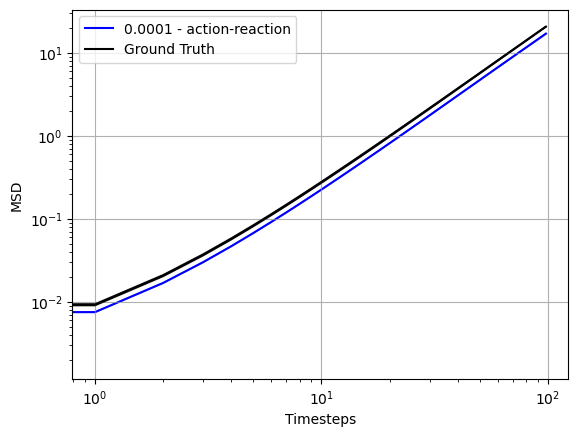

In [47]:
res_msd = []

# plot of MSD


for i in range(len(l1)):
    print(MSD_list_noisy[i][:limit_msd].shape)
    msd_mean = np.mean(MSD_list_noisy[i][:, :limit_msd], axis = 0)
    msd_std = np.std(MSD_list_noisy[i][:, :limit_msd], axis = 0)
    x = np.arange(limit_msd)
    plt.loglog(x, msd_mean, color = colors[i], zorder = 1, label = str(l1[i]))
    plt.fill_between((x), (msd_mean - msd_std), (msd_mean+msd_std), color = colors[i], alpha = 0.4, zorder = 2)
    
    res_msd.append(msd_mean)
    
msd_mean = np.mean(MSD_base_noisy[:, :limit_msd], axis = 0)
msd_std = np.std(MSD_base_noisy[:, :limit_msd], axis = 0)
x = np.arange(limit_msd)
plt.loglog(x, msd_mean, color = 'k', zorder = 1, label = 'Ground Truth')
plt.fill_between((x), (msd_mean - msd_std), (msd_mean+msd_std), color = 'k', alpha = 0.8, zorder = 2)
    
plt.xlabel('Timesteps')
plt.ylabel('MSD')
plt.grid()
plt.legend()
plt.savefig('MSD-simplest-noisy.png')



In [48]:
msd_gt = np.mean(MSD_base_noisy[:, :limit_msd], axis = 0)

In [49]:
for i in range(len(res_msd)):
    delta = (msd_gt - res_msd[i]) ** 2
    print(f'l1: {l1[i]} >>>> {np.mean(delta)} +- {np.std(delta)}')

l1: 0.0001 - action-reaction >>>> 2.817699532412619 +- 3.7164889721663514


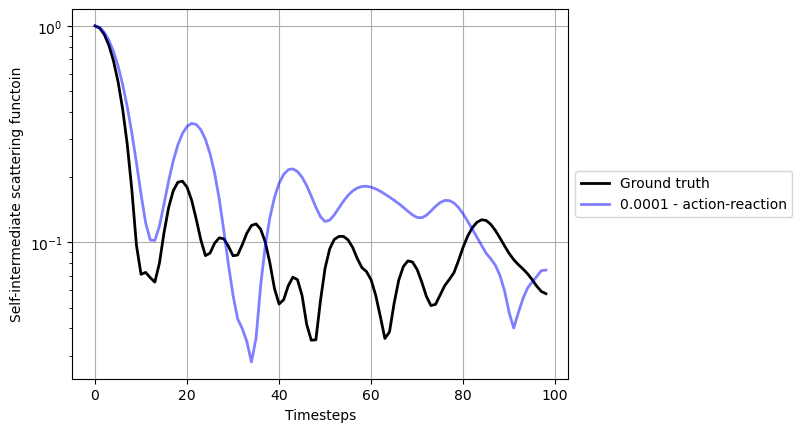

In [50]:
# plot of SSF

res_scat = []



ssf_mean = np.mean(SCAT_base_noisy[:, :limit_scat], axis = 0)
ssf_std = np.std(SCAT_base_noisy[:, :limit_scat], axis = 0)
t = np.arange(limit_scat)
plt.semilogy(t, ssf_mean, color = 'k', lw=2, label = 'Ground truth')
#plt.fill_between(t, ssf_mean -ssf_std,  ssf_mean + ssf_std, color = 'k', alpha = 0.2, zorder = 3)


for i in range(len(l1)):
    #print(MSD_list_noisy[i][:limit_scat].shape)
    ssf_mean = np.mean(SCAT_list_noisy[i][:, :limit_scat], axis = 0)
    ssf_std = np.std(SCAT_list_noisy[i][:, :limit_scat], axis = 0)
    t = np.arange(limit_scat)
    plt.semilogy(t, ssf_mean, color = colors[i], lw=2, label = str(l1[i]), alpha = 0.5)
    res_scat.append(ssf_mean)
    #plt.fill_between(t, ssf_mean -ssf_std,  ssf_mean + ssf_std, color = colors[i], alpha = 0.4, zorder = 2)
    
plt.xlabel('Timesteps')
plt.ylabel('Self-intermediate scattering functoin')
plt.grid()
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

plt.savefig('scat-simplest-noisy.png', bbox_inches='tight')
plt.show()

In [51]:
scat_gt = np.mean(SCAT_base_noisy[:, :limit_scat], axis = 0)

for i in range(len(res_scat)):
    delta = (scat_gt - res_scat[i]) ** 2
    print(f'l1: {l1[i]} >>>> {np.mean(delta)} +- {np.std(delta)}')

l1: 0.0001 - action-reaction >>>> 0.008661046411742673 +- 0.01061507387652624


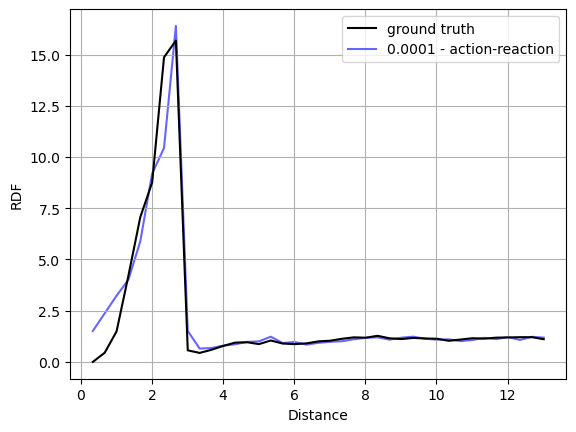

In [52]:
mean_res, std_res, r = RDF_base_noisy
lim_rdf = 40

res_rdf = []


mean_res, std_res, r = mean_res[1:lim_rdf], std_res[1: lim_rdf], r[1: lim_rdf]

plt.plot(r, mean_res, color = 'k', label = 'ground truth', zorder = 2)
#plt.fill_between(r, mean_res - std_res, mean_res+ std_res, color = 'k', alpha = 0.4)

for i in range(len(l1)):
    #print(MSD_list_noisy[i][:limit_scat].shape)
    mean_res, std_res, r = RDF_list_noisy[i]
    mean_res, std_res, r = mean_res[1:lim_rdf], std_res[1: lim_rdf], r[1: lim_rdf]
    
    plt.plot(r, mean_res, color = colors[i], label = str(l1[i]), alpha = 0.6, zorder = 1)
    #plt.fill_between(r, mean_res -std_res,  mean_res + std_res, color = colors[i], alpha = 0.4, zorder = 2)
    
    res_rdf.append(mean_res)

plt.xlabel('Distance')
plt.ylabel('RDF')
plt.grid()
plt.legend()


plt.savefig('rdf-simplest-noisy.png')
plt.show()

In [53]:
mean_res, std_res, r = RDF_base_noisy
mean_res, std_res, r = mean_res[1:lim_rdf], std_res[1: lim_rdf], r[1: lim_rdf]
rdf_gt = np.mean(mean_res, axis = 0)

for i in range(len(res_rdf)):
    delta = (rdf_gt - res_rdf[i]) ** 2
    print(f'l1: {l1[i]} >>>> {np.mean(delta)} +- {np.std(delta)}')

l1: 0.0001 - action-reaction >>>> 9.701362469348078 +- 33.90082547306547


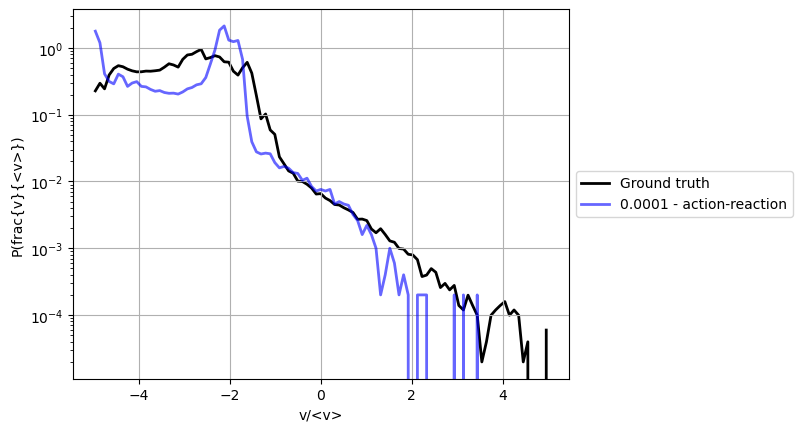

In [54]:
magn_base, x_speed, y_speed = DISTR_base_noisy

magn_base_mean = np.mean(magn_base, axis = 0)
magn_base_std = np.std(magn_base, axis = 0)

res_magn_distr = []


fig=plt.figure()
db=b[1]-b[0]
plt.grid()
plt.semilogy(b[1:]-db/2,magn_base_mean,'k',lw=2, zorder = 1, label = 'Ground truth')
#plt.fill_between(b[1:]-db/2, magn_base_mean - magn_base_std, magn_base_mean + magn_base_std, color = 'r', alpha = 0.4)


for i in range(len(l1)):
    magn, x, y = DISTR_list_noisy[i]
    magn_base_mean = np.mean(magn, axis = 0)
    magn_base_std = np.std(magn, axis = 0)
    plt.semilogy(b[1:]-db/2,magn_base_mean, color = colors[i],lw=2, label = str(l1[i]), zorder = 2, alpha = 0.6)
    
    res_magn_distr.append(magn_base_mean)



plt.xlabel('v/<v>')
plt.ylabel('P(frac{v}{<v>})')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

plt.savefig('speed-magn-simplest-noisy.png', bbox_inches='tight')
plt.show()

In [55]:
magn_base, x_speed, y_speed = DISTR_base_noisy

magn_base_mean = np.mean(magn_base, axis = 0)

magn_gt = magn_base_mean

for i in range(len(res_magn_distr)):
    delta = (magn_gt - res_magn_distr[i]) ** 2
    print(f'l1: {l1[i]} >>>> {np.mean(delta)} +- {np.std(delta)}')

l1: 0.0001 - action-reaction >>>> 0.1192421365061896 +- 0.37560010141516803


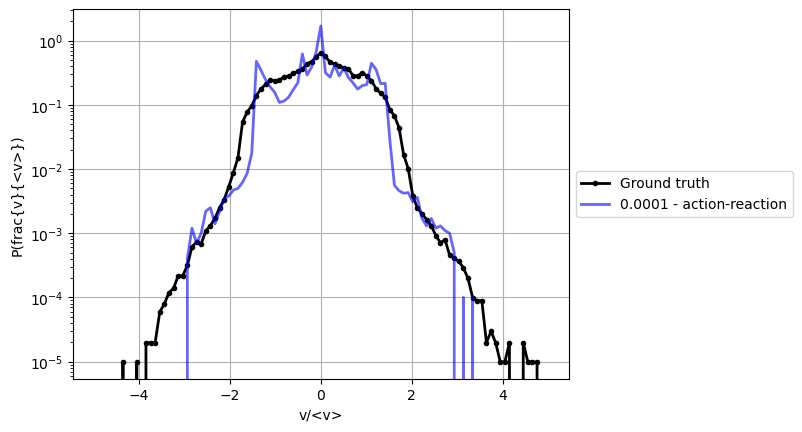

In [56]:
magn_base_mean = np.mean(x_speed, axis = 0)
magn_base_std = np.std(x_speed, axis = 0)

res_magn_x = []


fig=plt.figure()
db=b[1]-b[0]
plt.grid()
plt.semilogy(b[1:]-db/2,magn_base_mean,'k.-',lw=2, label = 'Ground truth')
#plt.fill_between(b[1:]-db/2, magn_base_mean - magn_base_std, magn_base_mean + magn_base_std, color = 'r', alpha = 0.4)


for i in range(len(l1)):
    magn, x, y = DISTR_list_noisy[i]
    x_base_mean = np.mean(x, axis = 0)
    x_base_std = np.std(x, axis = 0)
    plt.semilogy(b[1:]-db/2,x_base_mean, color = colors[i],lw=2, label = str(l1[i]), zorder = 2, alpha = 0.6)
    
    
    res_magn_x.append(x_base_mean)

    
plt.xlabel('v/<v>')
plt.ylabel('P(frac{v}{<v>})')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

plt.savefig('speed-x-simplest-noisy.png', bbox_inches='tight')
plt.show()

In [57]:
magn_base, x_speed, y_speed = DISTR_base_noisy

magn_base_mean = np.mean(x_speed, axis = 0)

magn_gt = magn_base_mean

for i in range(len(res_magn_x)):
    delta = (magn_gt - res_magn_x[i]) ** 2
    print(f'l1: {l1[i]} >>>> {np.mean(delta)} +- {np.std(delta)}')

l1: 0.0001 - action-reaction >>>> 0.017255023999059753 +- 0.10898113806916791


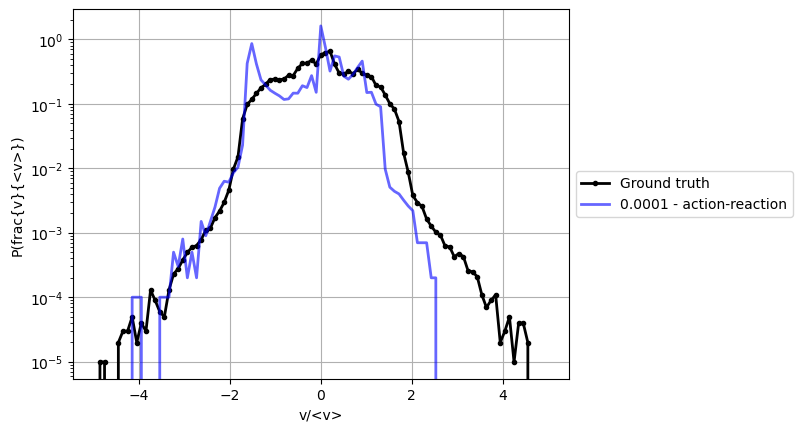

In [58]:
magn_base_mean = np.mean(y_speed, axis = 0)
magn_base_std = np.std(y_speed, axis = 0)

res_magn_y = []


fig=plt.figure()
db=b[1]-b[0]
plt.grid()
plt.semilogy(b[1:]-db/2,magn_base_mean,'k.-',lw=2, label = 'Ground truth')
#plt.fill_between(b[1:]-db/2, magn_base_mean - magn_base_std, magn_base_mean + magn_base_std, color = 'r', alpha = 0.4)


for i in range(len(l1)):
    magn, x, y = DISTR_list_noisy[i]
    y_base_mean = np.mean(y, axis = 0)
    y_base_std = np.std(y, axis = 0)
    plt.semilogy(b[1:]-db/2,y_base_mean, color = colors[i],lw=2, label = str(l1[i]), zorder = 2, alpha = 0.6)
    
    res_magn_y.append(y_base_mean)

plt.xlabel('v/<v>')
plt.ylabel('P(frac{v}{<v>})')




plt.xlabel('v/<v>')
plt.ylabel('P(frac{v}{<v>})')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

plt.savefig('speed-y-simplest-noisy.png', bbox_inches='tight')
plt.show()

In [59]:
magn_base, x_speed, y_speed = DISTR_base_noisy

magn_base_mean = np.mean(y_speed, axis = 0)

magn_gt = magn_base_mean

for i in range(len(res_magn_y)):
    delta = (magn_gt - res_magn_y[i]) ** 2
    print(f'l1: {l1[i]} >>>> {np.mean(delta)} +- {np.std(delta)}')

l1: 0.0001 - action-reaction >>>> 0.025108856687489182 +- 0.12097714753129639


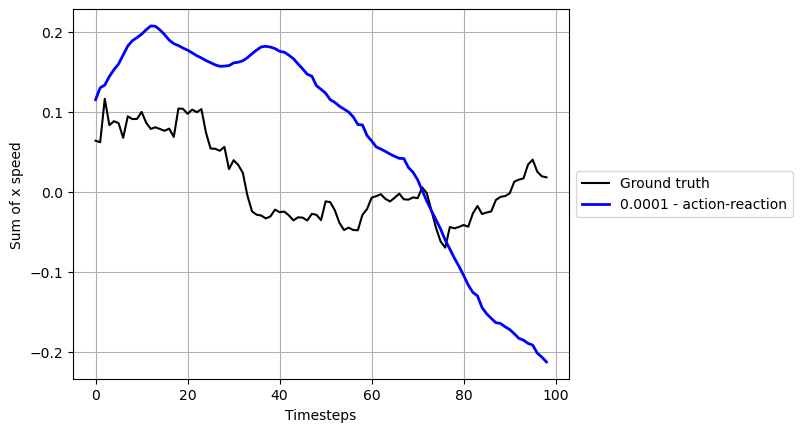

In [60]:
mean_sum = np.mean(SUM_base_noisy, axis = 0)
std_sum = np.std(SUM_base_noisy, axis = 0)

liit_sum = 300

plt.plot(mean_sum[:liit_sum, 0], color = 'k', label = 'Ground truth')


for i in range(len(l1)):
    sum_mean = np.mean(SUM_list_noisy[i], axis = 0)
    sum_std = np.std(SUM_list_noisy[i], axis = 0)
    
    plt.plot(sum_mean[:liit_sum, 0], color = colors[i], lw=2, label = str(l1[i]))

    
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.grid()
plt.xlabel('Timesteps')
plt.ylabel('Sum of x speed')

plt.savefig('speed-sum-x-simplest-noisy.png', bbox_inches='tight')
plt.show()

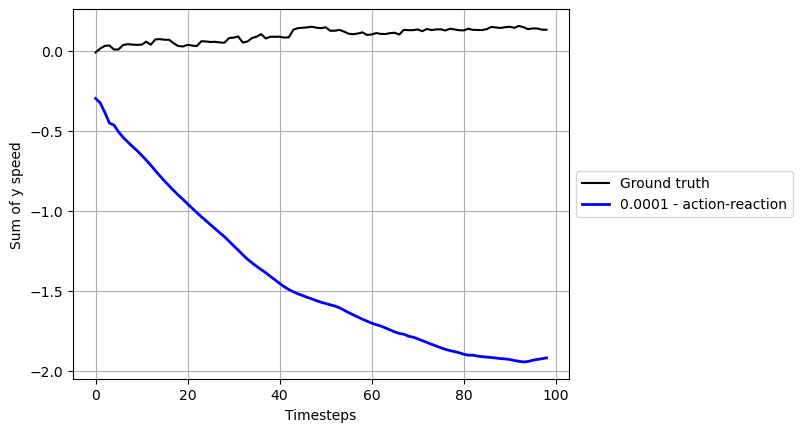

In [61]:
mean_sum = np.mean(SUM_base_noisy, axis = 0)
std_sum = np.std(SUM_base_noisy, axis = 0)

liit_sum = 300

plt.plot(mean_sum[:liit_sum, 1], color = 'k', label = 'Ground truth')


for i in range(len(l1)):
    sum_mean = np.mean(SUM_list_noisy[i], axis = 0)
    sum_std = np.std(SUM_list_noisy[i], axis = 0)
    
    plt.plot(sum_mean[:liit_sum, 1], color = colors[i], lw=2, label = str(l1[i]))

    
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.grid()
plt.xlabel('Timesteps')
plt.ylabel('Sum of y speed')


#plt.ylim([np.min(mean_sum[:liit_sum, 1])- 0.5, np.max(mean_sum[:liit_sum, 1])+ 0.5])

plt.savefig('speed-sum-y-simplest-noisy.png', bbox_inches='tight')
plt.show()